In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/Users/richardgrumitt/Documents/berkeley/NFMC_Jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import scipy
from scipy.stats import multivariate_normal as n_mvn
import corner
import torch
import warnings
import pickle

import jax
import jax.numpy as jnp

import torch.distributions
from nfmc_jax.DLA.base import PPDLMC, LatentDLA
from nfmc_jax.DLA.posterior import TorchPosterior, JaxPosterior
from nfmc_jax.DLA.debug import MultiStageDebugger
from nfmc_jax.flows.base import SINFInterface, RealNVPInterface, MAFInterface, RQNSFInterface, PPInterface, LinearGaussianInterface
from nfmc_jax.utils.torch_distributions import gaussian_log_prob, Funnel

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)

/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# High Condition Number Gaussian

In [54]:
num_dims = 100
gamma_shape = 0.5
lower = np.full(num_dims, -400.)
upper = np.full(num_dims, 400.)
np_bounds = np.array([lower, upper])
bounds_sinf = list([list(b) for b in np_bounds.T])

rng = np.random.RandomState(seed=10)
eigenvalues = np.sort(rng.gamma(shape=gamma_shape, scale=1.,
                      size=num_dims)).astype(np.float32)
q, _ = np.linalg.qr(rng.randn(num_dims, num_dims))
covariance = (q * eigenvalues**-1).dot(q.T).astype(np.float32)
covariance = torch.tensor(covariance, dtype=torch.float64)

cov_prior = 400 ** 2 * torch.eye(num_dims, dtype=torch.float64)
cov_like = torch.linalg.inv(torch.linalg.inv(covariance) - torch.linalg.inv(cov_prior))

recov_cov = torch.linalg.inv(torch.linalg.inv(cov_prior) + torch.linalg.inv(cov_like))
print(cov_like)

cov_prior = torch.tensor(cov_prior, dtype=torch.float32)
cov_like = torch.tensor(cov_like, dtype=torch.float32)

def log_like(x):
    return torch.distributions.MultivariateNormal(loc=torch.zeros(num_dims), 
                                                  covariance_matrix=cov_like).log_prob(x)

#v_log_like = lambda x: jax.vmap(log_like)(x)

def log_prior(x):
    return torch.distributions.MultivariateNormal(loc=torch.zeros(num_dims), 
                                                  covariance_matrix=cov_prior).log_prob(x)

#return jnp.sum(jax.scipy.stats.uniform.logpdf(x, loc=-10000, scale=20000))

#v_log_prior = lambda x: jax.vmap(log_prior)(x)

def prior_rvs(N):
    return torch.distributions.MultivariateNormal(loc=torch.zeros(num_dims), 
                                                  covariance_matrix=cov_prior).sample((N,))

posterior = TorchPosterior(log_likelihood = lambda x: log_like(x),
                           log_prior = lambda x: log_prior(x))

initial_samples = prior_rvs(5000)
#initial_samples = torch.randn((1000, num_dims))
print(initial_samples)
#initial_samples = torch.tensor(np.loadtxt('ill_cond_gauss_compact.txt'), dtype=torch.float32)

truth_samples = n_mvn.rvs(mean=np.zeros(num_dims), cov=covariance, size=(10000,))

tensor([[1586.4615,  208.6841, -344.1326,  ..., 1986.6845, 1503.7033,
         -182.3685],
        [ 208.6841,  132.9460,  -54.3127,  ...,  178.6286,  219.6948,
          -89.7056],
        [-344.1326,  -54.3127,  164.5912,  ..., -441.5386, -365.3578,
           76.3320],
        ...,
        [1986.6845,  178.6286, -441.5386,  ..., 2771.9648, 1897.7534,
         -176.9193],
        [1503.7033,  219.6948, -365.3578,  ..., 1897.7534, 1844.4771,
         -333.2011],
        [-182.3685,  -89.7056,   76.3320,  ..., -176.9193, -333.2011,
          173.7225]], dtype=torch.float64)
tensor([[  39.2845, -832.2716,  336.7932,  ..., -308.8348,  -54.3570,
         -113.7483],
        [ 277.6580, -393.1068,  156.8267,  ...,  334.8174,  476.2724,
          118.2751],
        [-507.4223,  770.2240, -474.4363,  ...,   24.9527, -392.1023,
         1020.2949],
        ...,
        [ 816.5132,  325.3384,  -54.2971,  ..., -724.7029,  635.9865,
          485.8215],
        [ 298.9424, -135.2121,   98.7404, 

/var/folders/j1/kb1kn_z17y5fmz9v5lbbhyyh0000gn/T/ipykernel_56982/208763884.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov_prior = torch.tensor(cov_prior, dtype=torch.float32)
/var/folders/j1/kb1kn_z17y5fmz9v5lbbhyyh0000gn/T/ipykernel_56982/208763884.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov_like = torch.tensor(cov_like, dtype=torch.float32)


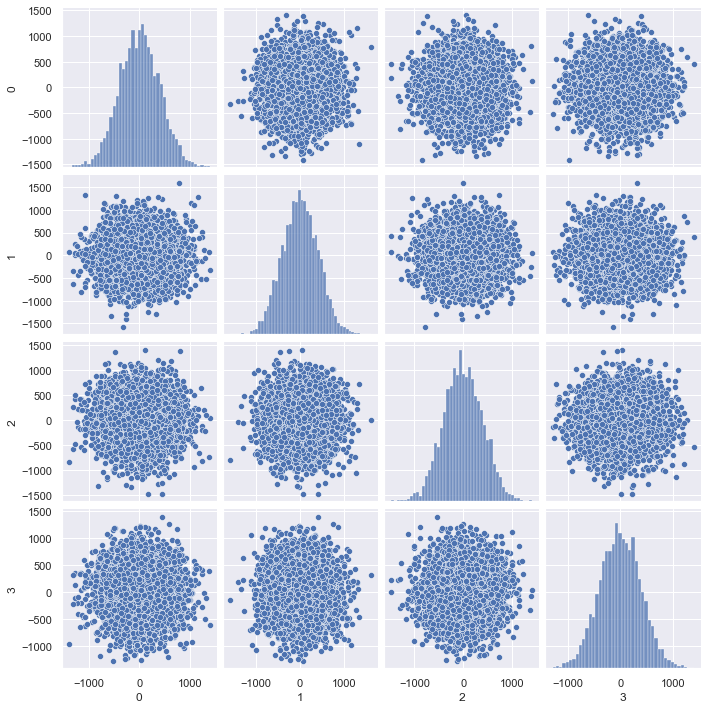

In [55]:
sns.pairplot(pd.DataFrame(initial_samples[:, 10:14]))

In [58]:
# Note - check about passing validation data to this.

flow_interface = SINFInterface()
flow_interface.create_flow(x=initial_samples,
                           val_frac=0.2,
                           iteration=50,
                           bounds=None,
                           alpha=(0.0, 0.98),
                           NBfirstlayer=True,
                           verbose=False,
                           M=None,
                           Whiten=False,
                           Whiten_with_weights=False,
                           Whiten_reg='OAS',
                           maxknot=False,
                           MSWD_max_iter=None)

In [59]:
burnin_interface = SINFInterface()
burnin_interface.create_flow(x=initial_samples,
                           val_frac=0.2,
                           iteration=5,
                           bounds=None,
                           alpha=(0.0, 0.98),
                           NBfirstlayer=True,
                           verbose=False,
                           M=None,
                           Whiten=False,
                           Whiten_with_weights=False,
                           Whiten_reg='OAS',
                           maxknot=False,
                           MSWD_max_iter=None)

In [60]:
#initial_samples = np.loadtxt('./fiducial_samples/ill_conditioned_gauss_iter500_N1000.txt')
#initial_samples = torch.tensor(initial_samples, dtype=torch.float32)

In [61]:
dlmc = LatentDLA(
    interface=flow_interface,
    burnin_interface=burnin_interface,
    posterior=posterior
)

xf, x_iter, qx_iter, var_iter, mean_iter = dlmc.run(initial_samples,
         main_step=1e-2,
         burnin_step=1e-2,
         burnin_optimizer='adagrad',
         optimizer='adagrad',
         optim_scheduler='identity',
         exp_decay_rate=0.99,
         cos_T_max=100,
         cos_lr_min=0.0,
         burnin_optim_steps=1,
         optim_steps=10,
         atol=1e-15,
         max_burnin=200,
         burnin_thresh=10.0,
         num_upsample=0,
         max_iterations=10,
         latent=True,
         IMHstep=1,
         CMHstep=0,
         CMHscale=0.1,
         ULMstep=0,
         stochastic_calibration=False,
         taylor_zeta=True,
         use_tqdm=True,
         post_ulm_steps=0,
         post_ulm_batch=20,
         animate_kwargs=dict(dpi=200),
         train_kwargs={'val_frac': 0.2},
         underdamped_kwargs={'step_size':1.0e-3, 'gamma': 2.0}
        )

  0%|                                                                                     | 0/210 [00:00<?, ?it/s]

Virial = 6062417.0
<sum_x_virial> = 6062417.0


[Stage 0] Beta: 1.0:   0%|▏                                         | 1/210 [00:02<07:14,  2.08s/it, accept_IMH=1]

Virial = 12443.888671875
<sum_x_virial> = 12443.888671875


[Stage 0] Beta: 1.0:   1%|▎                                      | 2/210 [00:04<06:58,  2.01s/it, accept_IMH=0.89]

Virial = 7630.2333984375
<sum_x_virial> = 7630.2333984375


[Stage 0] Beta: 1.0:   1%|▌                                      | 3/210 [00:06<06:55,  2.01s/it, accept_IMH=0.76]

Virial = 5665.8759765625
<sum_x_virial> = 5665.8759765625


[Stage 0] Beta: 1.0:   2%|▋                                     | 4/210 [00:08<06:51,  2.00s/it, accept_IMH=0.687]

Virial = 4543.6640625
<sum_x_virial> = 4543.6640625


[Stage 0] Beta: 1.0:   2%|▉                                     | 5/210 [00:09<06:47,  1.99s/it, accept_IMH=0.641]

Virial = 3805.316650390625
<sum_x_virial> = 3805.316650390625


[Stage 0] Beta: 1.0:   3%|█                                     | 6/210 [00:11<06:43,  1.98s/it, accept_IMH=0.603]

Virial = 3278.54541015625
<sum_x_virial> = 3278.54541015625


[Stage 0] Beta: 1.0:   3%|█▎                                    | 7/210 [00:13<06:41,  1.98s/it, accept_IMH=0.573]

Virial = 2864.17724609375
<sum_x_virial> = 2864.17724609375


[Stage 0] Beta: 1.0:   4%|█▍                                    | 8/210 [00:15<06:40,  1.98s/it, accept_IMH=0.555]

Virial = 2542.93603515625
<sum_x_virial> = 2542.93603515625


[Stage 0] Beta: 1.0:   4%|█▋                                    | 9/210 [00:17<06:41,  2.00s/it, accept_IMH=0.543]

Virial = 2274.73193359375
<sum_x_virial> = 2274.73193359375


[Stage 0] Beta: 1.0:   5%|█▊                                   | 10/210 [00:20<06:43,  2.02s/it, accept_IMH=0.534]

Virial = 2043.958740234375
<sum_x_virial> = 2043.958740234375


[Stage 0] Beta: 1.0:   5%|█▉                                   | 11/210 [00:22<06:41,  2.02s/it, accept_IMH=0.511]

Virial = 1850.53466796875
<sum_x_virial> = 1850.53466796875


[Stage 0] Beta: 1.0:   6%|██                                   | 12/210 [00:23<06:35,  2.00s/it, accept_IMH=0.506]

Virial = 1684.8311767578125
<sum_x_virial> = 1684.8311767578125


[Stage 0] Beta: 1.0:   6%|██▎                                  | 13/210 [00:25<06:30,  1.98s/it, accept_IMH=0.491]

Virial = 1540.02392578125
<sum_x_virial> = 1540.02392578125


[Stage 0] Beta: 1.0:   7%|██▍                                  | 14/210 [00:27<06:26,  1.97s/it, accept_IMH=0.471]

Virial = 1415.0455322265625
<sum_x_virial> = 1415.0455322265625


[Stage 0] Beta: 1.0:   7%|██▋                                  | 15/210 [00:29<06:21,  1.95s/it, accept_IMH=0.472]

Virial = 1301.0184326171875
<sum_x_virial> = 1301.0184326171875


[Stage 0] Beta: 1.0:   8%|██▊                                  | 16/210 [00:31<06:17,  1.95s/it, accept_IMH=0.456]

Virial = 1202.4267578125
<sum_x_virial> = 1202.4267578125


[Stage 0] Beta: 1.0:   8%|██▉                                  | 17/210 [00:33<06:14,  1.94s/it, accept_IMH=0.444]

Virial = 1116.444580078125
<sum_x_virial> = 1116.444580078125


[Stage 0] Beta: 1.0:   9%|███▏                                 | 18/210 [00:35<06:12,  1.94s/it, accept_IMH=0.429]

Virial = 1037.6826171875
<sum_x_virial> = 1037.6826171875


[Stage 0] Beta: 1.0:   9%|███▎                                 | 19/210 [00:37<06:10,  1.94s/it, accept_IMH=0.422]

Virial = 964.1802978515625
Reached virial threshold during burnin.
<sum_x_virial> = 964.1802978515625


[Stage 0] Beta: 1.0:  10%|███▌                                 | 20/210 [00:54<20:07,  6.36s/it, accept_IMH=0.422]

<sum_x_virial> = 897.7010498046875


[Stage 0] Beta: 1.0:  10%|███▋                                 | 21/210 [01:08<27:50,  8.84s/it, accept_IMH=0.422]

<sum_x_virial> = 866.5359497070312


[Stage 0] Beta: 1.0:  10%|███▉                                 | 22/210 [01:24<33:43, 10.76s/it, accept_IMH=0.422]

<sum_x_virial> = 844.7578735351562


[Stage 0] Beta: 1.0:  11%|████                                 | 23/210 [01:39<37:36, 12.07s/it, accept_IMH=0.422]

<sum_x_virial> = 827.4005126953125


[Stage 0] Beta: 1.0:  11%|████▏                                | 24/210 [01:54<40:19, 13.01s/it, accept_IMH=0.422]

<sum_x_virial> = 812.5632934570312


[Stage 0] Beta: 1.0:  12%|████▍                                | 25/210 [02:09<42:18, 13.72s/it, accept_IMH=0.422]

<sum_x_virial> = 799.8792724609375


[Stage 0] Beta: 1.0:  12%|████▌                                | 26/210 [02:25<43:42, 14.25s/it, accept_IMH=0.422]

<sum_x_virial> = 788.1887817382812


[Stage 0] Beta: 1.0:  13%|████▊                                | 27/210 [02:40<44:35, 14.62s/it, accept_IMH=0.422]

<sum_x_virial> = 777.29443359375


[Stage 0] Beta: 1.0:  13%|████▉                                | 28/210 [02:56<45:29, 15.00s/it, accept_IMH=0.422]

<sum_x_virial> = 767.91455078125


[Stage 0] Beta: 1.0:  14%|█████                                | 29/210 [03:12<45:40, 15.14s/it, accept_IMH=0.422]

<sum_x_virial> = 758.881103515625


[Stage 0] Beta: 1.0:  14%|█████▎                               | 30/210 [03:27<45:55, 15.31s/it, accept_IMH=0.422]

<sum_x_virial> = 750.7425537109375


[Stage 0] Beta: 1.0:  15%|█████▍                               | 31/210 [03:43<21:31,  7.21s/it, accept_IMH=0.422]


Reached maximum number of post-burnin DLMC iterations.


0it [00:00, ?it/s]


In [62]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='q', truth_label='Truth', out_name=None, levels=5):

    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(q_samples)] = q_label
        labels[len(q_samples):] = truth_label
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
        weights = q_weights


    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]

    df = pd.DataFrame(d)
    print(df)

    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.map_offdiag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)

      labels      $x_0$     $x_1$      $x_2$
0          q   7.450785  2.671186 -16.266039
1          q  12.883570  6.959160 -11.115700
2          q  10.629964  5.171191 -12.573063
3          q  15.795311  2.934817 -10.646379
4          q   7.438449 -6.207836  -8.546070
...      ...        ...       ...        ...
14995      T  -0.443181  0.918555 -13.992237
14996      T -47.856283 -7.266189  10.868735
14997      T  14.838636  9.731027   7.343339
14998      T  56.164545 -3.900494 -12.181675
14999      T -16.235635  1.764195  -3.444175

[15000 rows x 4 columns]


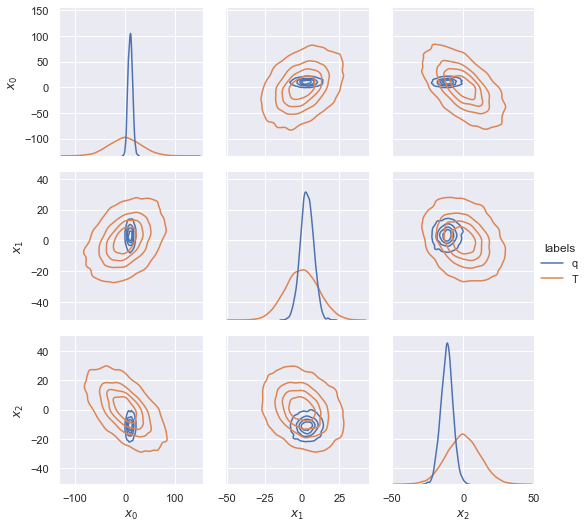

In [63]:
sns_pairplot(xf[:, 0:3], np.ones(len(xf)), truth_samples[:, 0:3])
#np.savetxt('ill_cond_gauss_compact.txt', xf)

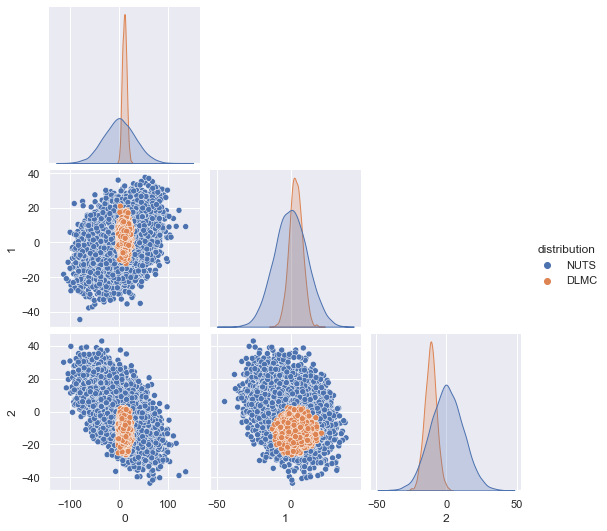

In [64]:
df = pd.concat([
    pd.DataFrame(truth_samples[:, 0:3]),
    pd.DataFrame(xf[:, 0:3].numpy()),
]).reset_index(drop=True)
df['distribution'] = ['NUTS'] * len(truth_samples) + \
                     ['DLMC'] * len(xf)

sns.pairplot(df, corner=True, hue='distribution')

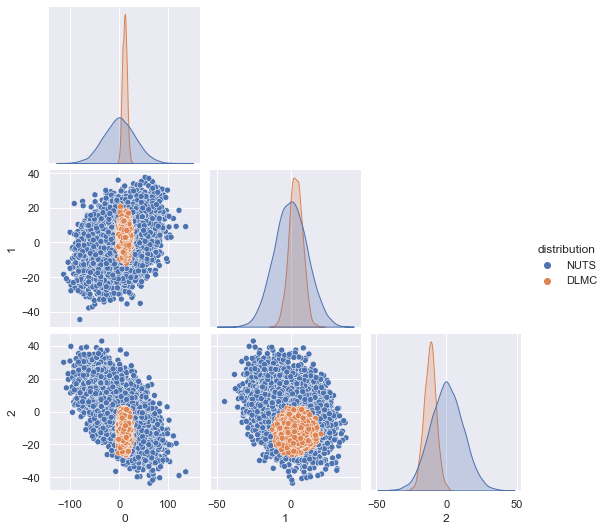

In [65]:
xi = x_iter['20']
df = pd.concat([
    pd.DataFrame(truth_samples[:, 0:3]),
    pd.DataFrame(xi[:, 0:3].numpy()),
]).reset_index(drop=True)
df['distribution'] = ['NUTS'] * len(truth_samples) + \
                     ['DLMC'] * len(xi)

sns.pairplot(df, corner=True, hue='distribution')

      labels      $x_0$      $x_1$      $x_2$
0          q  -3.727992  15.041847  -3.111194
1          q  -2.815806   8.505060  -7.437345
2          q -16.597580  43.370014 -15.427374
3          q   2.445078  17.767769  15.172110
4          q -10.025219   0.653051 -16.102917
...      ...        ...        ...        ...
14995      T -49.165086  -1.499784  10.618737
14996      T -25.044166 -12.668251   3.611893
14997      T -33.131152  -4.270532  24.043542
14998      T  -3.383118  -2.201607   3.644769
14999      T -44.420602   0.072930  17.978840

[15000 rows x 4 columns]


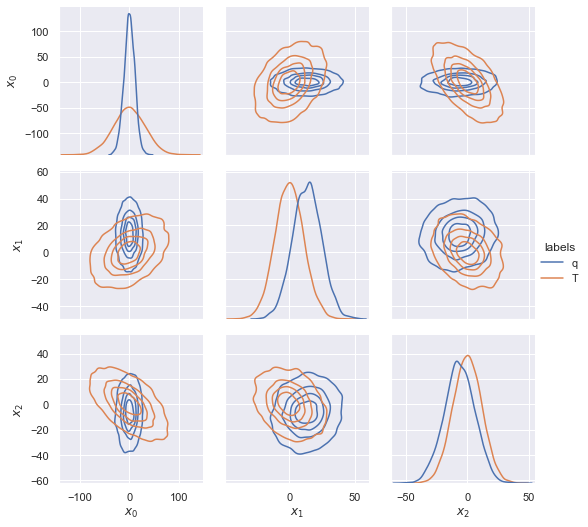

In [63]:
xi = x_iter['2']
#np.savetxt('./fiducial_samples/ill_conditioned_gauss_iter500_N1000.txt', xi)
sns_pairplot(xi[:, 0:3], np.ones(len(xi)), truth_samples[:, 0:3])

      labels      $x_0$      $x_1$      $x_2$
0          q  -4.028370   2.839684   1.940151
1          q   5.436614   5.826184  16.019600
2          q  -5.025103  22.974688   6.312842
3          q   7.148056  12.126814  -1.152345
4          q   1.798128   2.670050   7.310551
...      ...        ...        ...        ...
14995      T   0.097661 -10.324420  12.720429
14996      T  -1.422419 -16.239247  26.125377
14997      T  -8.087339 -12.464936  18.023676
14998      T  10.241642   4.166127  -9.685302
14999      T  -2.164365  -7.878039  41.035053

[15000 rows x 4 columns]


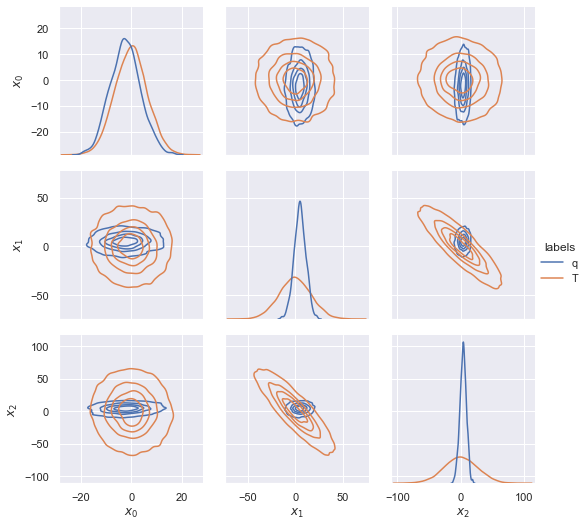

In [55]:
qxi = qx_iter['10'] 
sns_pairplot(qxi[:, 90:93], np.ones(len(qxi)), truth_samples[:, 90:93])

     labels     $x_0$      $x_1$      $x_2$
0         q -4.028370   2.839684   1.940151
1         q  5.436614   5.826184  16.019600
2         q -5.025103  22.974688   6.312842
3         q  7.148056  12.126814  -1.152345
4         q  1.798128   2.670050   7.310551
...     ...       ...        ...        ...
9995      T -3.881237   6.701591   6.576506
9996      T -6.891001  -1.781376  12.842704
9997      T -1.359986   9.350979  -0.333752
9998      T -0.610621  14.136215   1.531830
9999      T  7.166313   4.819912   2.821192

[10000 rows x 4 columns]


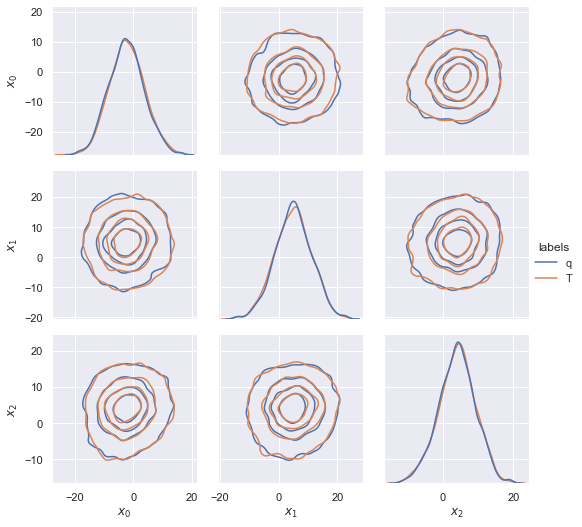

In [56]:
sns_pairplot(qxi[:, 90:93], np.ones(len(qxi)), xi[:, 90:93])

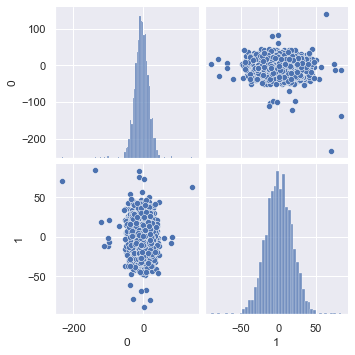

In [18]:
sns.pairplot(pd.DataFrame(xi[:, 1:3]))

In [73]:
qx = dlmc.interface.sample(1000)

In [74]:
dlmc.interface.flow

SINF(
  (layer): ModuleList(
    (0): SlicedTransport(
      (transform1D): RQspline()
    )
    (1): SlicedTransport(
      (transform1D): RQspline()
    )
    (2): SlicedTransport(
      (transform1D): RQspline()
    )
    (3): SlicedTransport(
      (transform1D): RQspline()
    )
    (4): SlicedTransport(
      (transform1D): RQspline()
    )
    (5): SlicedTransport(
      (transform1D): RQspline()
    )
    (6): SlicedTransport(
      (transform1D): RQspline()
    )
    (7): SlicedTransport(
      (transform1D): RQspline()
    )
    (8): SlicedTransport(
      (transform1D): RQspline()
    )
    (9): SlicedTransport(
      (transform1D): RQspline()
    )
    (10): SlicedTransport(
      (transform1D): RQspline()
    )
    (11): SlicedTransport(
      (transform1D): RQspline()
    )
    (12): SlicedTransport(
      (transform1D): RQspline()
    )
    (13): SlicedTransport(
      (transform1D): RQspline()
    )
    (14): SlicedTransport(
      (transform1D): RQspline()
    )
    (1

     labels      $x_0$      $x_1$
0         q   4.955444   8.347098
1         q -13.621942   9.027454
2         q  -9.042659   9.748633
3         q -10.881386   7.400987
4         q -12.388734 -27.967567
...     ...        ...        ...
5995      T  -8.005967   4.911195
5996      T  -9.480704   2.667938
5997      T  -7.257060  -2.192447
5998      T  -5.788616   7.092761
5999      T  -6.395059  12.125587

[6000 rows x 3 columns]


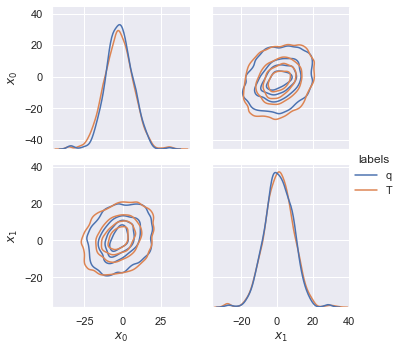

In [75]:
sns_pairplot(qx[:, 0:2], np.ones(len(qx)), xf[:, 0:2])

# Debug

In [95]:
def generate_alum_noise(ndim: int,
                        step_size: np.float64,
                        gamma: np.float64,
                        alpha: torch.Tensor):
    # Generate the noise terms for ALUM version of underdamped Langevin.
    e_xh = torch.zeros((alpha.shape[0], ndim))
    e_vh = torch.zeros((alpha.shape[0], ndim))
    e_xah = torch.zeros((alpha.shape[0], ndim))
    
    gamma = torch.tensor(gamma, dtype=torch.float64)
    step_size = torch.tensor(step_size, dtype=torch.float64)

    for i, a in enumerate(alpha):
        cov_xtxt = (2.0 * gamma * step_size - 3.0 + 4.0 * torch.exp(-gamma * step_size) - torch.exp(
            -2.0 * gamma * step_size)) / gamma ** 2
        cov_xtvt = (4.0 * torch.sinh(gamma * step_size / 2.0) ** 2 * torch.exp(-gamma * step_size)) / gamma
        cov_vtvt = (1.0 - torch.exp(-2.0 * gamma * step_size))
        cov_xtxat = (2.0 * a * gamma * step_size - 2.0 - 4.0 * torch.exp(-gamma * step_size) * torch.sinh(
            a * gamma * step_size / 2.0) ** 2 + 2.0 * torch.exp(-a * gamma * step_size)) / gamma ** 2
        cov_vtxat = 4.0 * torch.sinh(a * gamma * step_size / 2.0) ** 2 * torch.exp(
            -gamma * step_size) / gamma
        cov_xatxat = (2.0 * a * gamma * step_size - 3.0 + 4.0 * torch.exp(-a * gamma * step_size) - torch.exp(
            - 2.0 * a * gamma * step_size)) / gamma ** 2
        print(f'cov_xtxt = {cov_xtxt}')
        print(f'cov_xtvt = {cov_xtvt}')
        print(f'cov_vtvt = {cov_vtvt}')
        print(f'cov_xtxat = {cov_xtxat}')
        print(f'cov_vtxat = {cov_vtxat}')
        print(f'cov_xatxat = {cov_xatxat}')
        
        block_row1 = torch.cat([cov_xtxt * torch.eye(ndim), cov_xtvt * torch.eye(ndim), cov_xtxat * torch.eye(ndim)], 
                               dim=1)
        block_row2 = torch.cat([cov_xtvt * torch.eye(ndim), cov_vtvt * torch.eye(ndim), cov_vtxat * torch.eye(ndim)], 
                               dim=1)
        block_row3 = torch.cat([cov_xtxat * torch.eye(ndim), cov_vtxat * torch.eye(ndim), cov_xatxat * torch.eye(ndim)], 
                               dim=1)
        cov_alum = torch.cat([block_row1, block_row2, block_row3], dim=0)

        noise_vec = torch.distributions.MultivariateNormal(loc=torch.zeros(cov_alum.shape[0]),
                                                           covariance_matrix=cov_alum).sample((1,)).squeeze()
        e_xh[i, :] = noise_vec[:ndim]
        e_vh[i, :] = noise_vec[ndim:2 * ndim]
        e_xah[i, :] = noise_vec[2 * ndim:]

    return e_xh, e_vh, e_xah

In [91]:
alpha = np.random.uniform(low=0.0, high=1.0, size=(1,))
#alpha = torch.rand((1,))
print(f'alpha = {alpha}')
e_xh, e_vh, e_xah = generate_alum_noise(32, 1e-3, 2.0, alpha)
print(f'e_xh = {e_xh}')
print(f'e_vh = {e_vh}')
print(f'e_xah = {e_xah}')

alpha = [0.99423308]
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 1.319824471934794e-09
cov_vtxat = 1.973049451328544e-06
cov_xatxat = 1.3084460459555913e-09
e_xh = tensor([[ 5.9601e-05,  1.8742e-05,  4.5975e-05,  2.9533e-05,  2.2176e-05,
          7.4947e-05,  5.7717e-05,  1.2823e-06, -3.5168e-05, -5.7493e-06,
          3.1194e-05, -1.5852e-05,  3.1197e-05,  1.7467e-05, -3.2889e-06,
          6.2739e-05, -4.1405e-05,  1.2737e-05, -6.5482e-05, -2.9896e-06,
          3.6806e-05,  3.8545e-05, -4.7239e-06, -3.6237e-05,  5.1058e-05,
         -4.0554e-05,  3.0236e-05, -4.4694e-05,  2.9375e-05, -4.0066e-05,
          4.8714e-05,  5.7628e-07]])
e_vh = tensor([[ 0.1328,  0.0692,  0.0789,  0.0792,  0.1147,  0.1143,  0.1125,  0.0315,
         -0.1019, -0.0441,  0.0939, -0.0425,  0.0604,  0.0047,  0.0038,  0.1378,
         -0.0333,  0.0168, -0.0897, -0.0065,  0.0821,  0.0869,  0.0351, -0.0263,
          0.0728, -0.0741,  0.0852, -0

(array([0]),)


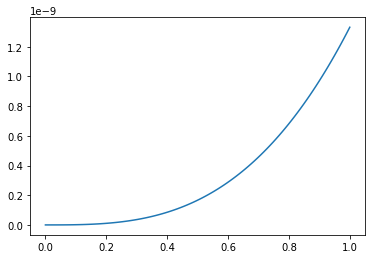

In [75]:
f = lambda ndim, step_size, gamma, a: (2.0 * a * gamma * step_size - 3.0 + 4.0 * np.exp(-a * gamma * step_size) - np.exp(
            - 2.0 * a * gamma * step_size)) / gamma ** 2

f(32, 1e-3, 2.0, alpha)

alpha_vals = np.linspace(0, 1.0, 100)
print(np.where(f(32, 1e-3, 2.0, alpha_vals) == 0.0))
plt.plot(alpha_vals, f(32, 1e-3, 2.0, alpha_vals))

In [37]:
f(32, 1e-3, 2.0, torch.tensor(0.3185))

tensor(1.4901e-08)

In [38]:
f(32, 1e-3, 2.0, 0.3185)

4.3058612231305915e-11

In [107]:
def generate_alum_noise2(ndim: int,
                         step_size: np.float64,
                         gamma: np.float64,
                         alpha: torch.Tensor,
                         taylor: bool = False):
    # Generate the noise terms for ALUM version of underdamped Langevin.
    e_xh = torch.zeros((alpha.shape[0], ndim))
    e_vh = torch.zeros((alpha.shape[0], ndim))
    e_xah = torch.zeros((alpha.shape[0], ndim))
    
    for i, a in enumerate(alpha):
        if not taylor:
            cov_xtxt = (2.0 * gamma * step_size - 3.0 + 4.0 * np.exp(-gamma * step_size) - np.exp(
                -2.0 * gamma * step_size)) / gamma ** 2
            cov_xtvt = (4.0 * np.sinh(gamma * step_size / 2.0) ** 2 * np.exp(-gamma * step_size)) / gamma
            cov_vtvt = (1.0 - np.exp(-2.0 * gamma * step_size))
            cov_xtxat = (2.0 * a * gamma * step_size - 2.0 - 4.0 * np.exp(-gamma * step_size) * np.sinh(
                a * gamma * step_size / 2.0) ** 2 + 2.0 * np.exp(-a * gamma * step_size)) / gamma ** 2
            cov_vtxat = 4.0 * np.sinh(a * gamma * step_size / 2.0) ** 2 * np.exp(
                -gamma * step_size) / gamma
            cov_xatxat = (2.0 * a * gamma * step_size - 3.0 + 4.0 * np.exp(-a * gamma * step_size) - np.exp(
                - 2.0 * a * gamma * step_size)) / gamma ** 2
        elif taylor:
            cov_xtxt = 2.0 * (gamma * step_size) ** 3 / 3.0
            cov_xtvt = gamma * step_size ** 2 * (1.0 - gamma * step_size)
            cov_vtvt = 2.0 * gamma * step_size * (1.0 - gamma * step_size + 2.0 * (gamma * step_size) ** 2 / 3.0)
            cov_xtxat = a ** 2 * gamma * step_size ** 3 * (1.0 - a / 3.0)
            cov_vtxat = a ** 2 * gamma * step_size ** 2 * (1.0 - gamma * step_size)
            cov_xatxat = 2.0 * (a * gamma * step_size) ** 3 / 3.0
        print(f'cov_xtxt = {cov_xtxt}')
        print(f'cov_xtvt = {cov_xtvt}')
        print(f'cov_vtvt = {cov_vtvt}')
        print(f'cov_xtxat = {cov_xtxat}')
        print(f'cov_vtxat = {cov_vtxat}')
        print(f'cov_xatxat = {cov_xatxat}')
        
        if cov_xatxat <= 0:
            print(f'2.0 * a * gamma * step_size = {2.0 * a * gamma * step_size}')
            print(f'4.0 * np.exp(-a * gamma * step_size) = {4.0 * np.exp(-a * gamma * step_size)}')
            print(f'np.exp(- 2.0 * a * gamma * step_size) = {np.exp(- 2.0 * a * gamma * step_size)}')
        
        cov_alum = torch.tensor([[cov_xtxt, cov_xtvt, cov_xtxat],
                                 [cov_xtvt, cov_vtvt, cov_vtxat],
                                 [cov_xtxat, cov_vtxat, cov_xatxat]], dtype=torch.float32)

        noise_vec = torch.distributions.MultivariateNormal(loc=torch.zeros(cov_alum.shape[0]),
                                                           covariance_matrix=cov_alum).sample((ndim,)).squeeze()
        e_xh[i, :] = noise_vec[:, 0]
        e_vh[i, :] = noise_vec[:, 1]
        e_xah[i, :] = noise_vec[:, 2]

    return e_xh, e_vh, e_xah

In [101]:
alpha = np.random.uniform(low=0, high=1, size=(100,))
e_xh2, e_vh2, e_xah2 = generate_alum_noise2(32, 1e-3, 2.0, alpha)
print(e_xh2.shape)

cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 9.72210423277886e-10
cov_vtxat = 1.3359044721975642e-06
cov_xatxat = 7.291665327091579e-10
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 2.0544849155257339e-10
cov_vtxat = 2.3155947346883664e-07
cov_xatxat = 5.265848868063472e-11
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 4.384698160109224e-11
cov_vtxat = 4.614421522558399e-08
cov_xatxat = 4.685696275430473e-12
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 9.069351381008062e-10
cov_vtxat = 1.227039538989728e-06
cov_xatxat = 6.419093034892853e-10
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 8.312959765000016e-10
cov_vtxat = 1.1046756040993724e-06
cov_xatxat = 5.4835788

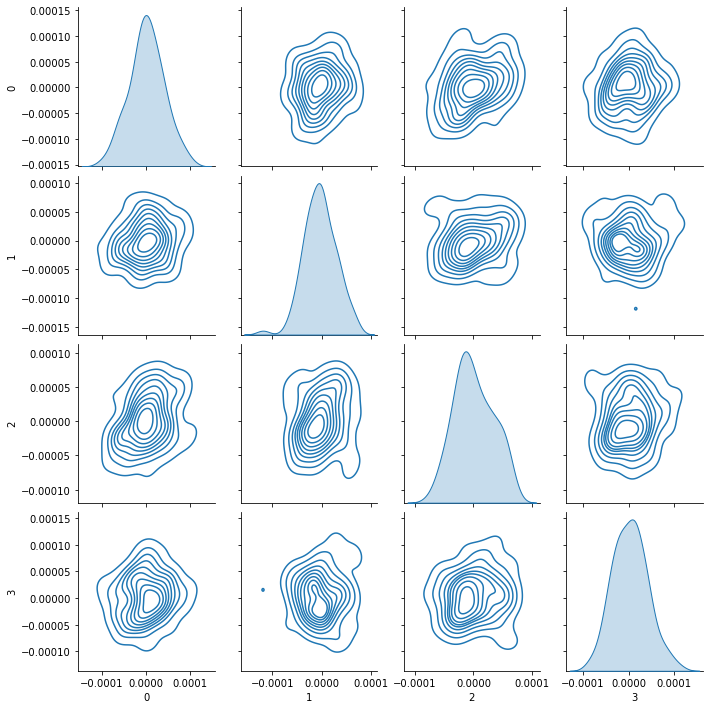

In [93]:
sns.pairplot(pd.DataFrame(e_xh2[:, 0:4].numpy()), kind='kde')

In [98]:
alpha = np.random.uniform(low=0, high=1, size=(100,))
alpha = torch.tensor(alpha, dtype=torch.float64)
e_xh, e_vh, e_xah = generate_alum_noise(32, 1.0e-3, 2.0, alpha)

cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 9.528422495463928e-10
cov_vtxat = 1.3032785915374374e-06
cov_xatxat = 7.026289827738452e-10
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 1.185916420620714e-09
cov_vtxat = 1.7153007279019394e-06
cov_xatxat = 1.0607255629402346e-09
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 2.5653257296198717e-11
cov_vtxat = 2.6655470233987012e-08
cov_xatxat = 2.057326531357262e-12
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 8.748740620845297e-11
cov_vtxat = 9.423165323076076e-08
cov_xatxat = 1.3672563081712497e-11
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 8.293569164763426e-10
cov_vtxat = 1.1015905620390375e-06
cov_xatxat = 5.460

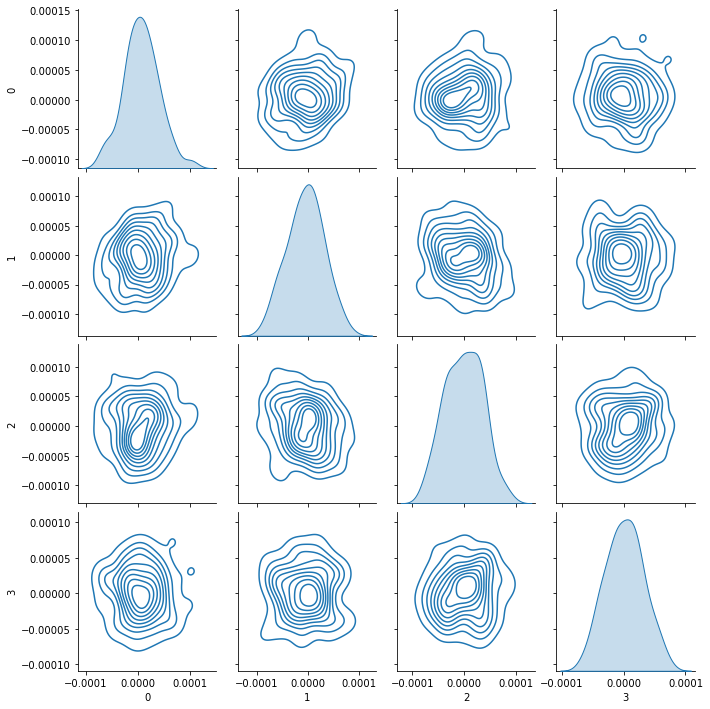

In [99]:
sns.pairplot(pd.DataFrame(e_xh[:, 0:4].numpy()), kind='kde')

    labels     $x_0$         $x_1$         $x_2$         $x_3$
0        q -0.000041  1.930139e-06  1.543943e-05  2.320784e-05
1        q -0.000054 -4.461500e-06  2.935514e-05  4.020344e-06
2        q  0.000001 -3.273755e-07  4.520668e-09 -3.533919e-07
3        q -0.000004 -9.435558e-07  6.705373e-07  8.064995e-07
4        q  0.000020 -1.067190e-05 -2.845234e-06  1.231867e-05
..     ...       ...           ...           ...           ...
195      T -0.000006 -3.578503e-06 -5.043788e-06 -5.145952e-06
196      T  0.000016 -2.328139e-05 -4.242879e-05  1.805111e-05
197      T -0.000014 -1.306053e-05  1.271722e-05  1.802192e-05
198      T -0.000001 -3.198136e-06 -3.655255e-06 -8.626909e-06
199      T -0.000005 -1.981012e-06  1.716293e-07  2.107354e-06

[200 rows x 5 columns]


/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/ho

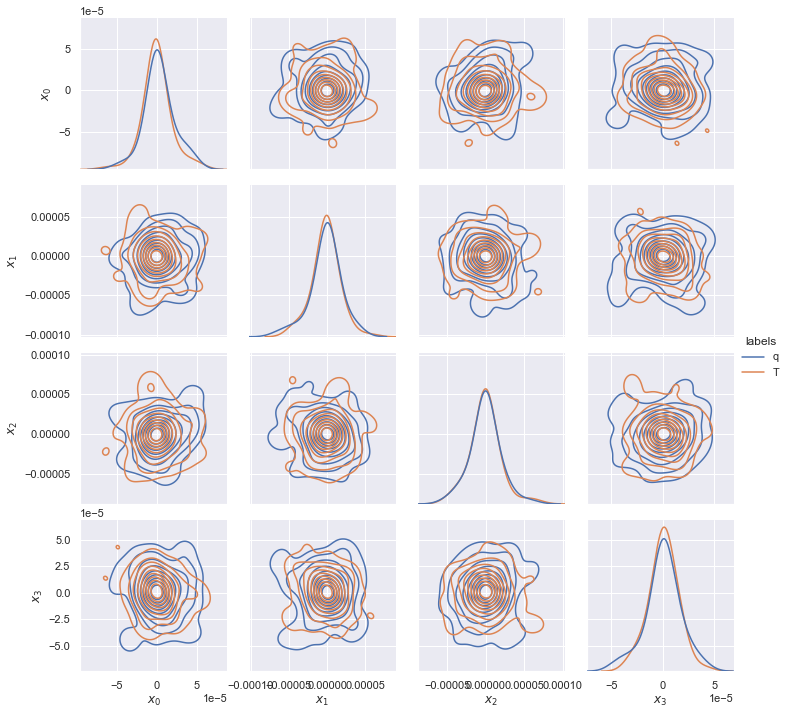

In [106]:
sns_pairplot(e_xah[:, 0:4], np.ones(len(e_xh)), e_xah2[:, 0:4])

In [108]:
te_xh2, te_vh2, te_xah2 = generate_alum_noise2(32, 1e-3, 2.0, alpha, taylor=True)

cov_xtxt = 5.333333333333334e-09
cov_xtvt = 1.996e-06
cov_vtvt = 0.003992010666666667
cov_xtxat = 9.73547788068888e-10
cov_vtxat = 1.3359014987886357e-06
cov_xatxat = 2.9202469442555967e-09
cov_xtxt = 5.333333333333334e-09
cov_xtvt = 1.996e-06
cov_vtvt = 0.003992010666666667
cov_xtxat = 2.056803377869998e-10
cov_vtxat = 2.315590007774301e-07
cov_xatxat = 2.1074167267338132e-10
cov_xtxt = 5.333333333333334e-09
cov_xtvt = 1.996e-06
cov_vtvt = 0.003992010666666667
cov_xtxat = 4.389321671081102e-11
cov_vtxat = 4.6144122458418756e-08
cov_xatxat = 1.8747031511257384e-11
cov_xtxt = 5.333333333333334e-09
cov_xtvt = 1.996e-06
cov_vtvt = 0.003992010666666667
cov_xtxat = 9.081635583185514e-10
cov_vtxat = 1.227036830196626e-06
cov_xatxat = 2.5706581081740418e-09
cov_xtxt = 5.333333333333334e-09
cov_xtvt = 1.996e-06
cov_vtvt = 0.003992010666666667
cov_xtxat = 8.32401937217332e-10
cov_vtxat = 1.1046731880087451e-06
cov_xatxat = 2.195880197722229e-09
cov_xtxt = 5.333333333333334e-09
cov_xtvt = 1.996e

    labels     $x_0$     $x_1$     $x_2$     $x_3$
0        q  0.046296  0.098652  0.083101  0.025477
1        q -0.057289 -0.037674 -0.005685  0.033873
2        q  0.160883  0.080169  0.006064 -0.038378
3        q -0.029040  0.045831  0.048976  0.059197
4        q  0.058131 -0.037097 -0.002977  0.000303
..     ...       ...       ...       ...       ...
195      T -0.118399 -0.041020 -0.133668 -0.117960
196      T  0.089511 -0.072090 -0.065181  0.109019
197      T -0.128541 -0.004776  0.030482  0.014055
198      T -0.126198  0.016780 -0.049618 -0.095654
199      T  0.010822 -0.000789 -0.007617  0.104492

[200 rows x 5 columns]


/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/ho

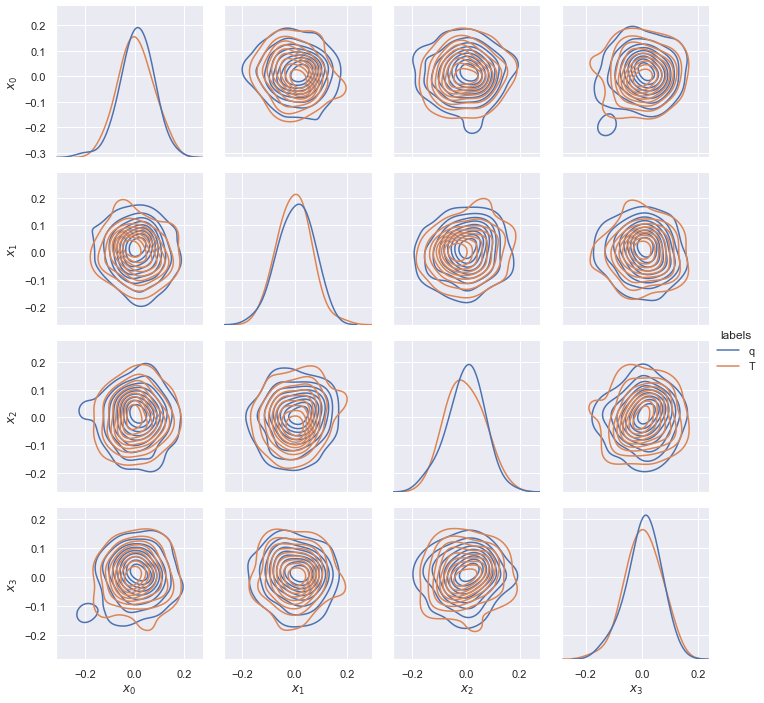

In [111]:
sns_pairplot(te_vh2[:, 0:4], np.ones(len(e_xh)), e_vh2[:, 0:4])